# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Оглавление проекта

1. [Общая информация о данных.](#start)


2. [Предобработка данных.](#preprocess)


3. [Расчет необходимых параметров для дальнейшего анализа.](#postprocess)


4. [Исследовательский анализ данных.](#research)

    * [Гистограммы для основных значений: площадь, цена, число комнат, высота потолков](#hist1)
    * [Временя продажи квартиры](#hist2)
    * [Поиск выбросов](#ejections)
    * [Поиск взаимосвязей](#dependence)
    * [Top-10 населенных пунктов по числу объявлений о продаже квартир](#top10)
    * [Анализ центра Санкт-Петербурга](#center)
    
    
5. [Общий вывод.](#result)

### Шаг 1. Общая информация о данных. <a id="start"></a>

Импортируем все библиотеки для последующей работы и прочитаем файл, разделим данные из файла табуляцией (\t).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

Посмотрим на таблицу и после выведем общую информацию и описание таблицы.

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


### Выводы

Мы вывели основную информацию о данных методами info и describe. В нашем распоряжении данные о 23699 объявлениях о продаже квартир и 22 колонки с параметрами квартир. Данные далеки от идеальных, поэтому потребуется их предобработка. Во многих колонках есть пропущенные значения, есть данные, у которых требуется поменять тип и в дальнейшем, скорее всего, будут найдены еще более интересные артефакты. Сейчас мы видим, что есть квартиры с площадью 900 кв.м. и квартиры-крошки в 12 кв.м., при медиане в 52 кв.м., есть 19 комнатные квартиры и есть где комнаты 0(не указано), квартиры с потолками 100м. и с потолком 1м., и объявление, которое «провисело» более 4-х лет при среднем времени размещения объявления в полгода. 

Также стоит отметить, что данные о количестве парков и прудов, а также расстояния до них и расстояние до аэропорта не требуются для поставленной цели анализа - эти данные будут проигнорированы.


### Шаг 2. Предобработка данных <a id="preprocess"></a>

Начнем с заполнения пропущенных значений. Предположим, что пустые значения в колонках balcony и is_apartment появились по причине не заполнения этих данных, т.к. балконов в квартире нет и квартира не является апартаментами (таких квартир большинство). Обратим внимание на то, что значения в столбцах разные balcony - float, is_apartment - object.

In [6]:
df['balcony'] = df['balcony'].fillna(0)
df['is_apartment'] = df['is_apartment'].fillna(0)

Проверим, что за квартиры с нулевыми комнатами.

In [7]:
#df[df['rooms']==0]
df.query('rooms<5').pivot_table(index='rooms', values='total_area', aggfunc=['median','count'])

,median,count
,total_area,total_area
rooms,,
0,26.05,197
1,36.56,8047
2,53.00,7940
3,73.00,5814
4,99.30,1180


Мы видим, что нулевые комнаты - это квартиры с маленькой площадью, скорее всего это квартиры-студии и пользователь не указывает количество комнат. Оставим нули без изменения, т.к. если заполнить нули единицами, то это может "сбить" площади и цены по однушкам в нашем фрейме. 

Просто будем иметь в виду, что нули это квартиры-студии, комнаты или кгт (квартиры гостиничного типа).

Заполним медианой значения расстояния до центра города - сгруппируем по названию населенного пункта. Если значения не заполнятся, то значит такой населенный пункт один в таблице и по нему невозможно сгруппировать данные для расчета медианы.

In [8]:
print('Количество пропусков в cityCenters_nearest до замены:', df['cityCenters_nearest'].isna().sum())

Количество пропусков в cityCenters_nearest до замены: 5519


In [9]:
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'cityCenters_nearest'].median()
    df.loc[(df['cityCenters_nearest'].isna()) & (df['locality_name'] == locality_name), 'cityCenters_nearest'] = median

In [10]:
print('Количество пропусков в cityCenters_nearest после замены:', df['cityCenters_nearest'].isna().sum())

Количество пропусков в cityCenters_nearest после замены: 5394


Для дальнейшего анализа нам потребуется информация о высоте потолка.

Заполним пропущенные данные ceiling_height медианами.
Создадим переменную medians_ceiling в которой сохраним таблицу сгрупированную по столбцу floors_total и locality_name и применим метод agg(), который будет рассчитывать медианное значение по ключу ceiling_height.

In [11]:
print('Количество пропусков в ceiling_height до замены:', df['ceiling_height'].isna().sum())

Количество пропусков в ceiling_height до замены: 9195


In [12]:
medians_ceiling = (df.groupby(['floors_total','locality_name'])
                   .agg({'ceiling_height':'median'})
                   .rename(columns = {'ceiling_height':'median_ceiling_height'}))
df = df.merge(medians_ceiling, on=['floors_total','locality_name'], how='left')
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['median_ceiling_height']

In [13]:
print('Количество пропусков в ceiling_height после замены:', df['ceiling_height'].isna().sum())

Количество пропусков в ceiling_height после замены: 503


После замены остались пропуски. Посмотрим на эти строки, а также удалим колонку с медианами.

In [14]:
df = df.drop(['median_ceiling_height'], axis=1)
df[df['ceiling_height'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,0,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
86,15,4500000.0,63.0,2018-07-17T00:00:00,2,NaN,11.0,36.0,3,0,...,9.0,2.0,посёлок Металлострой,26128.0,27825.0,0.0,NaN,0.0,NaN,100.0
92,10,4200000.0,72.0,2017-11-17T00:00:00,2,NaN,12.0,45.0,4,0,...,10.0,0.0,поселок городского типа Кузьмоловский,NaN,NaN,NaN,NaN,NaN,NaN,54.0
110,6,3850000.0,72.3,2017-09-29T00:00:00,2,NaN,3.0,27.4,2,0,...,23.6,0.0,деревня Пикколово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
164,6,800000.0,40.3,2018-06-25T00:00:00,2,NaN,3.0,NaN,1,0,...,NaN,2.0,поселок городского типа Ефимовский,NaN,NaN,NaN,NaN,NaN,NaN,81.0


Большую часть пропусков в высоте потолка мы убрали, пропуски остались по причине того, что это потолки квартир в маленьких населенных пунктах - на наш анализ отстутсвие этих значений не повлияет. Удалим строки без значения потолков.

In [15]:
df = df.dropna(subset=['ceiling_height']).reset_index(drop=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23196 non-null  int64  
 1   last_price            23196 non-null  float64
 2   total_area            23196 non-null  float64
 3   first_day_exposition  23196 non-null  object 
 4   rooms                 23196 non-null  int64  
 5   ceiling_height        23196 non-null  float64
 6   floors_total          23187 non-null  float64
 7   living_area           21404 non-null  float64
 8   floor                 23196 non-null  int64  
 9   is_apartment          23196 non-null  object 
 10  studio                23196 non-null  bool   
 11  open_plan             23196 non-null  bool   
 12  kitchen_area          21042 non-null  float64
 13  balcony               23196 non-null  float64
 14  locality_name         23182 non-null  object 
 15  airports_nearest   

В данных были обнаружены пропущенные значения в столбцах floors_total, living_area,  kithen_area, locality_name, days_exposition, cityCenters_nearest - это данные, которые потребуются в той или иной мере для анализа, но  "добыть" правдоподобную инфрмацию по этим параметрам проблематично. Оставим эти значения с пропусками как есть.

Данные airports_nearest, park_around3000, ponds_around3000, park_nearest и ponds_nearest - в исследование применятся не будут.

Предположим по каким причинам могут отсутствовать данные:

* floors_total - пользователь мог не внести подобную информацию в объявление;
* living_area, kithen_area - указана только общая площадь квартиры, опять недозаполнили объявления;
* locality_name, cityCenters_nearest - не указан геотег по объявлению или пользователь указал адрес квартиры в неверной графе, в связи с чем картографические данные не удалось выгрузить автоматически;
* days_exposition - на момент выгрузки данных, квартира могла быть еще не продана и объявление числилось как активное без даты снятия с публикации.



Поменяем типы данных на int:
* по  количеству балконов, т.к. не может быть полбалкона
* по значению is_apartment, т.к. это булевы значения, где 0 - False, 1 - True
* по значению last_price, для удобства


In [17]:
df[['balcony','is_apartment','last_price']] = df[['balcony','is_apartment','last_price']].astype(int)

Приведем значения в колонке с днем первой публикации к формату читаемой даты для дальнейшего анализа.

In [18]:
df['first_day_exposition'] = (pd.to_datetime(df['first_day_exposition'],
                                             format='%Y-%m-%d'))

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23196 non-null  int64         
 1   last_price            23196 non-null  int64         
 2   total_area            23196 non-null  float64       
 3   first_day_exposition  23196 non-null  datetime64[ns]
 4   rooms                 23196 non-null  int64         
 5   ceiling_height        23196 non-null  float64       
 6   floors_total          23187 non-null  float64       
 7   living_area           21404 non-null  float64       
 8   floor                 23196 non-null  int64         
 9   is_apartment          23196 non-null  int64         
 10  studio                23196 non-null  bool          
 11  open_plan             23196 non-null  bool          
 12  kitchen_area          21042 non-null  float64       
 13  balcony         

Посмотрим на строки с пропущенными этажами, их всего 9.

In [20]:
df[df['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8296,19,13500000,77.8,2019-04-17,2,2.80,NaN,39.41,21,0,...,13.27,2,Санкт-Петербург,12838.0,11477.0,1.0,593.0,1.0,130.0,NaN
9842,9,3350000,25.0,2018-09-10,1,2.65,NaN,17.00,21,0,...,3.50,0,посёлок Шушары,NaN,24212.0,NaN,NaN,NaN,NaN,23.0
10333,12,14900000,100.0,2018-10-02,3,2.80,NaN,51.00,4,0,...,40.00,0,Санкт-Петербург,30766.0,8059.0,0.0,NaN,1.0,213.0,140.0
13954,13,14000000,94.0,2019-01-23,6,2.65,NaN,51.00,23,0,...,16.30,0,Санкт-Петербург,51333.0,13056.0,0.0,NaN,0.0,NaN,NaN
16308,0,15950000,108.0,2017-10-24,3,2.80,NaN,NaN,3,0,...,NaN,0,Санкт-Петербург,26402.0,5249.0,0.0,NaN,2.0,444.0,91.0
19814,5,6060000,60.6,2015-10-29,2,2.80,NaN,NaN,2,0,...,NaN,0,Санкт-Петербург,35231.0,13301.0,0.0,NaN,1.0,830.0,1257.0
21191,4,7143060,44.7,2019-01-11,1,3.00,NaN,13.79,19,0,...,NaN,0,Санкт-Петербург,9222.0,11340.0,0.0,NaN,0.0,NaN,NaN
22064,5,8500000,63.5,2017-05-24,2,2.80,NaN,NaN,3,0,...,NaN,0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
23156,6,3063600,43.8,2016-11-28,1,2.70,NaN,14.00,8,0,...,15.50,2,Санкт-Петербург,8426.0,12082.0,2.0,24.0,1.0,271.0,246.0


Уберем эти 9 строк, так как взаимосвязи нет - это квартиры с разной площадь, этажами, в разных населенных пунктах и с разным временем публикации объявлений.

In [21]:
df = df.dropna(subset=['floors_total']).reset_index(drop=True)

Заменим типы данных.

In [22]:
df['floors_total'] = df['floors_total'].astype(int)
df['is_apartment'] = df['is_apartment'].astype('bool')

Предположим, что parks_around3000 и ponds_around3000 нет данных в связи с отсутствием парков и прудов в радиусе 3-х километров. Заполним пропущенные данные нулем и переведем в int.

In [23]:
df[['parks_around3000', 'ponds_around3000']] = df[['parks_around3000', 'ponds_around3000']].fillna(0)
df[['parks_around3000', 'ponds_around3000']] = df[['parks_around3000', 'ponds_around3000']].astype(int)

Заполним пропуски в days_exposition. Так как мы решили, что есть объявления, которые на момент выгрузки данных были еще активные, то у них по этому параметру проставлен "нет данных". Найдем максимальную дату публикации (последнюю дату публикации) и вычтем из нее количество дней размещения объявления - применим это только к пропущенным значениям. 

После переведем в int.

In [24]:
date_max = df['first_day_exposition'].max()

In [25]:
df.loc[df['days_exposition'].isna(),
            'days_exposition']  = (date_max - df.loc[df['days_exposition'].isna(), 
            'first_day_exposition']).dt.days

In [26]:
df['days_exposition'] = df['days_exposition'].astype(int)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23187 entries, 0 to 23186
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23187 non-null  int64         
 1   last_price            23187 non-null  int64         
 2   total_area            23187 non-null  float64       
 3   first_day_exposition  23187 non-null  datetime64[ns]
 4   rooms                 23187 non-null  int64         
 5   ceiling_height        23187 non-null  float64       
 6   floors_total          23187 non-null  int64         
 7   living_area           21398 non-null  float64       
 8   floor                 23187 non-null  int64         
 9   is_apartment          23187 non-null  bool          
 10  studio                23187 non-null  bool          
 11  open_plan             23187 non-null  bool          
 12  kitchen_area          21037 non-null  float64       
 13  balcony         

После таких преобразований мы сэкономили около 8% памяти, то является очень значительным в тех случаях, когда речь идет о BigData.

### Шаг 3. Расчет необходимых параметров для дальнейшего анализа. <a id="postprocess"></a>

Посчитаем и добавим в таблицу цену квадратного метра недвижимости.

In [28]:
df['price_per_meter'] = df['last_price'] / df['total_area']

После получения цены квадратного метра переведем цену квартиры в миллионы для дальнейшего удобства.

In [29]:
df['last_price'] = df['last_price']/1000000

Добавим в таблицу день недели, месяц и год публикации.

In [30]:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

Напишем функцию для группировки данных об этажах - первый, последний или другие.

In [31]:
def floor_group(floor):
    floors_total = floor['floors_total']
    floor = floor['floor']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другие'

Добавим в таблицу новый столбец floor_group, применим написанную функцию к строкам фрейма.

In [32]:
df['floor_group'] = df.apply(floor_group, axis = 1)

Добавим в таблицу отношения жилой площади к общей и отношение площади кухни к общей площади.

In [33]:
df['living_to_total'] = df['living_area'] / df['total_area'] 
df['kitchen_to_total'] = df['kitchen_area'] / df['total_area'] 

Посмотрим на наши преобразования.

In [34]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_to_total,kitchen_to_total
0,20,13.000,108.0,2019-03-07,3,2.700,16,51.0,8,False,...,2,755.0,57,120370.370370,3,3,2019,другие,0.472222,0.231481
1,10,5.196,56.0,2015-08-20,2,2.600,5,34.3,4,False,...,2,574.0,558,92785.714286,3,8,2015,другие,0.612500,0.148214
2,0,64.900,159.0,2015-07-24,3,2.600,14,NaN,9,False,...,3,234.0,424,408176.100629,4,7,2015,другие,NaN,NaN
3,2,10.000,100.0,2018-06-19,2,3.030,14,32.0,13,False,...,1,48.0,121,100000.000000,1,6,2018,другие,0.320000,0.410000
4,10,2.890,30.4,2018-09-10,1,2.625,12,14.4,5,False,...,0,NaN,55,95065.789474,0,9,2018,другие,0.473684,0.299342


Данные готовы для исследовательского анализа. Всё, что было возможно поменять, не потеряв смысля мы поменяли. Значения NaN, которые заменить не представляется возможным мы оставили в таблице.

### Шаг 4. Исследовательский анализ данных. <a id="research"></a>

##### Построим гистограммы для основных значений: площадь, цена, число комнат, высота потолков, выведем основные данные по этим значениям методом describe. <a id="hist1"></a>

* ##### Гистограмма по площади квартир:

In [35]:
df['year'].value_counts()

2018    8331
2017    8047
2019    2816
2016    2701
2015    1155
2014     137
Name: year, dtype: int64

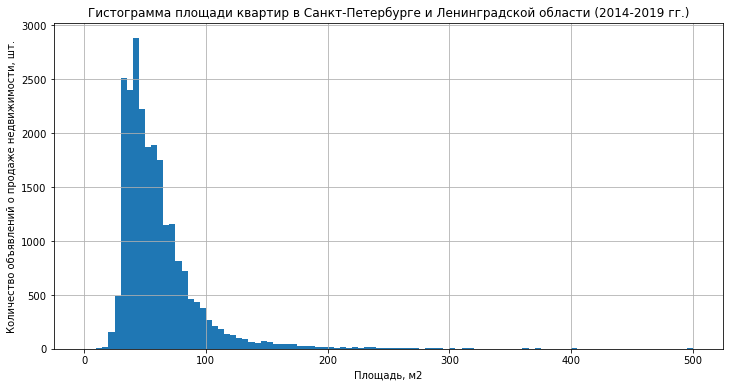

count    23187.000000
mean        60.504287
std         35.855101
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

In [36]:
df['total_area'].hist(bins=100, figsize=(12,6), range=(0,500))
plt.title('Гистограмма площади квартир в Санкт-Петербурге и Ленинградской области (2014-2019 гг.)')
plt.xlabel('Площадь, м2')
plt.ylabel('Количество объявлений о продаже недвижимости, шт.')
plt.show()
df['total_area'].describe()

По гистограмме мы видим широкий пик в диапазоне площадей от 30 до 70 м². По описанию мы видим, что медианной площадью является - 52 м² - это соответствуют типовым двухкомнатным квартирам в наше время. Есть часть квартир с площадями меньше - минимальное значение 12 м². График идет на спад после площади 70 м², после 100 м² квартир уже совсем мало, но доходит отдельными значениями до 900 м².

По квартилям видно, что в основном продаются однушки ~40 м², двушки ~ 52 м² и трешки ~ 70 м². 

* ##### Гистограмма по цене квартир (до этого мы перевели значения last_price в миллионы):

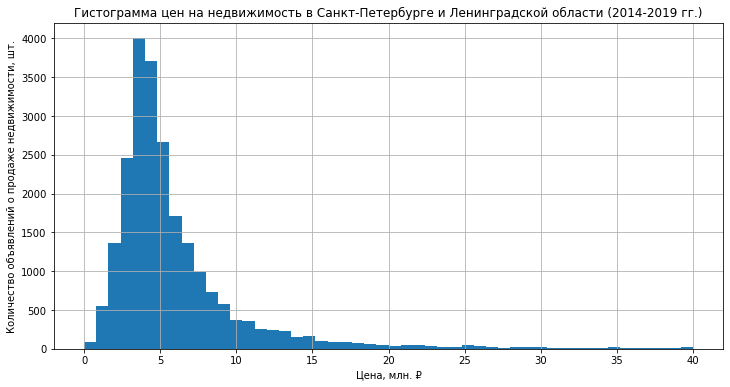

count    23187.000000
mean         6.606196
std         10.986890
min          0.012190
25%          3.482500
50%          4.690000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

In [37]:
df['last_price'].hist(bins=50, figsize=(12,6), range=(0,40))
plt.title('Гистограмма цен на недвижимость в Санкт-Петербурге и Ленинградской области (2014-2019 гг.)')
plt.xlabel('Цена, млн. ₽')
plt.ylabel('Количество объявлений о продаже недвижимости, шт.')
plt.show()
df['last_price'].describe()

Самый широкий пик гистограммы приходится на цены от 4 до почти 5 миллионов рублей. Минимальное значение по цене - 12 тысяч рублей, что скорее всего является ошибкой при заполнении объявлений. Достаточно много квартир выставляют на продажу по цене от 5 до 9 миллионов, далее значения убывают.

* ##### Гистограмма по количеству комнат:

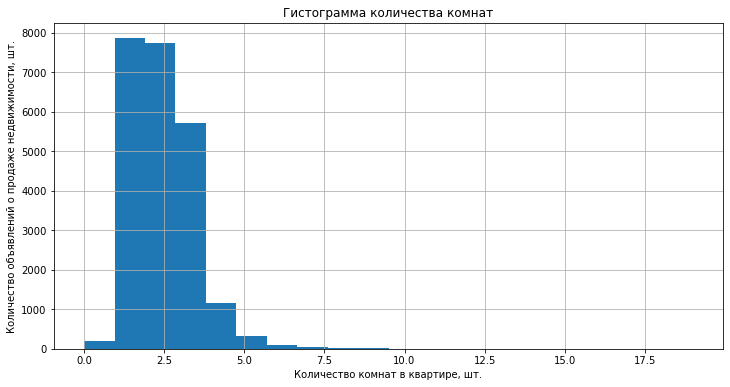

count    23187.000000
mean         2.075215
std          1.081929
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [38]:
df['rooms'].hist(bins=20,figsize=(12,6))
plt.title('Гистограмма количества комнат')
plt.xlabel('Количество комнат в квартире, шт.')
plt.ylabel('Количество объявлений о продаже недвижимости, шт.')
plt.show()
df['rooms'].describe()

Ожидаемый пик основных значений от одной комнаты до трех. Очень мало квартир-студий. Четырех-комнатые и пяти-комнатные квартиры встречаются уже сильно реже, после гистограмма совсем спадает. По описанию видим, что максимальное значение 19 комнат - это либо выброс, либо кто-то действительно продает большую квартиру, а может кто-то решил продать дворец, ведь, в Питере и окрестностях куча дворцов.

Также стоит отметить, что по количеству комнат очень низкая величина стандартного отклонения - 1,08.

* ##### Гистограмма по высоте потолков:

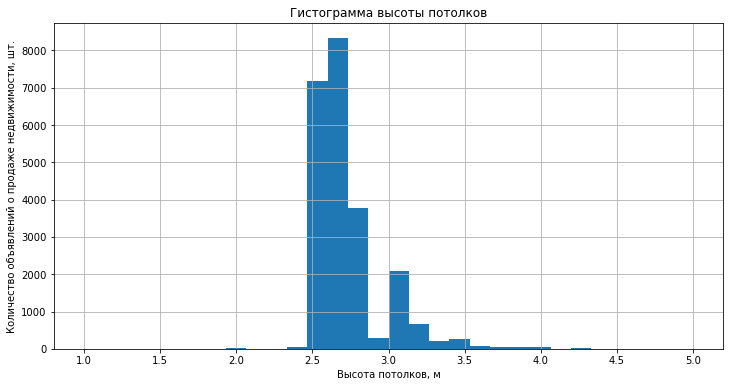

count    23187.000000
mean         2.739511
std          1.017360
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

In [39]:
df['ceiling_height'].hist(bins=30, figsize=(12,6), range=(1,5))
plt.title('Гистограмма высоты потолков')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество объявлений о продаже недвижимости, шт.')
plt.show()
df['ceiling_height'].describe()

Пик находится между значений от 2.5 до 3 метров. От 3 до 3.5 метров квартиры есть, но сильно меньше. Максимальное значение 100 метров, минимальное 1, наверняка ошибка или нежелание заполнять нормально объявление пользователем.

Тут стандартное отклонение тоже невелико - 1, значит разброс по высоте потолков небольшой.
Медиана 2.65, 1-ый квартиль - 2.55, 3-ий квартиль - 2.75.

* #####  Посмотрим на значения времени продажи квартиры, отдельно выведем среднее время продажи и медиану. <a id="hist2"></a>

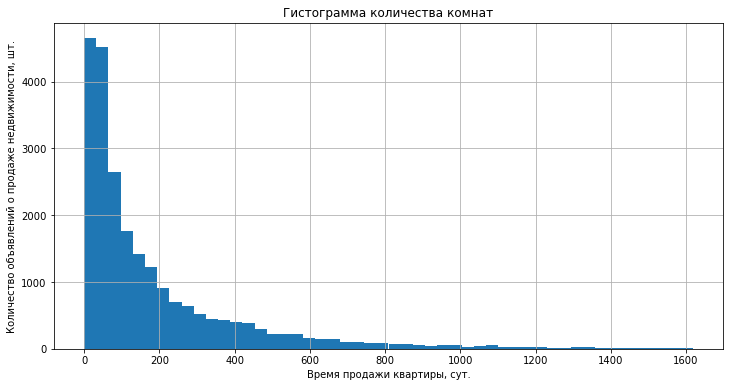

count    23187.000000
mean       186.600509
std        234.378761
min          0.000000
25%         43.000000
50%         94.000000
75%        238.000000
max       1618.000000
Name: days_exposition, dtype: float64

In [40]:
df['days_exposition'].hist(bins=50, figsize=(12,6))
plt.title('Гистограмма количества комнат')
plt.xlabel('Время продажи квартиры, сут.')
plt.ylabel('Количество объявлений о продаже недвижимости, шт.')
plt.show()
df['days_exposition'].describe()

In [41]:
print('Среднее время продажи квартиры {:.2f} дней.'.format(df['days_exposition'].mean()))
print('Медина времени продажи квартиры {:.2f} дней.'.format(df['days_exposition'].median()))

Среднее время продажи квартиры 186.60 дней.
Медина времени продажи квартиры 94.00 дней.


В среднем квартиры продаются полгода (186 дней), по медиане мы видим, что квартиры продаются 94 дня.

Считаю логичным отнести быстрые продажи квартиры к значениям вокруг первого квартиля - если квартира продалась от 30 до 60 дней, то можем считать это быстрой продажей. 

Значения гистограммы подходят к нулю после объявлений, "провисевших" более 800 дней (более двух лет), после этого значения продажи квартир, считаю становится необычно долгими. Также можем считать, что просто долгая продажа может считаться после года с момента публикации объявления.

#### Для выявления выбросов в данных построим боксплоты по основным параметрам. <a id="ejections"></a>

* Взглянем на типичное количество комнат для недвижимости в Петербурге и окрестностях.

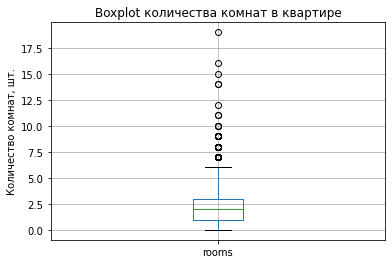

In [42]:
df.boxplot(column='rooms')
plt.title('Boxplot количества комнат в квартире')
plt.ylabel('Количество комнат, шт.')
plt.show()

**Типовыми** квартирами в Питере и его окрестностях будем считать **от однушек до шестикомнатных квартир** (коммуналки). Остальные значения можно считать за выбросы - это нетипичные квартиры с большим количеством комнат и, скорее всего, с большой площадью и ценой.

* Боксплот для цены. Так как разброс большой, сделаем боксплот с ограничением по квартилям, чтобы было наглядно видно где выбросы.

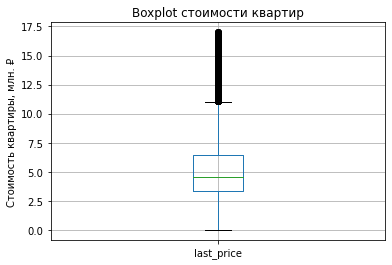

In [43]:
Q1 = df['last_price'].quantile(0.25)
Q3 = df['last_price'].quantile(0.75)
IQR = Q3
#df.query('last_price > 1').boxplot(column='last_price')
df.query('@Q1-1.5*@IQR < last_price < @Q3+1.5*@IQR').boxplot(column='last_price')
plt.title('Boxplot стоимости квартир')
plt.ylabel('Стоимость квартиры, млн. ₽')
plt.show()

Первый квартиль в значения около трех миллионов. Но в значения "нижнего уса" попадают очень низкие значения - возможно продают маленькие квартиры в отдаленных от центра местах или комнаты в квартирах, возможно кто-то не дописал пару нулей в объявлении. Нижнюю границу предлагаю взять от 800 тысяч рублей. Выбросами будут считать значения более 12 миллионов.

* Найдем выбросы для площади.

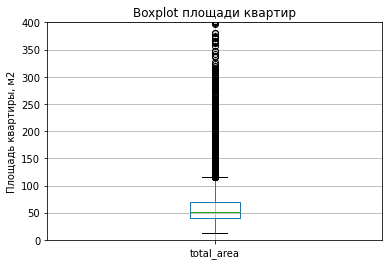

In [44]:
plt.ylim(0,400)
df.boxplot(column='total_area')
plt.title('Boxplot площади квартир')
plt.ylabel('Площадь квартиры, м2')
plt.show()

Значения более 120 квадратов уже нетипичны для Санкт-Петербурга и считаются выбросами, но выбросов много - элитная и большая по площади недвижимость есть и её относительно много.

* Определим нетипичное в потолках.

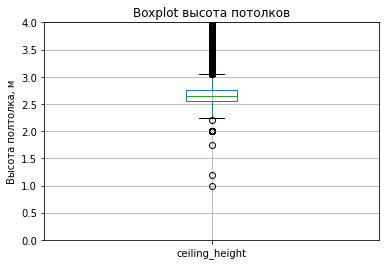

In [45]:
plt.ylim(0, 4)
df.boxplot(column='ceiling_height')
plt.title('Boxplot высота потолков')
plt.ylabel('Высота полтолка, м')
plt.show()

В "усы" укладывается высота потолка со значением от 2.3 метров до 3.1 метра - таких квартир большинство. Хотя наверное 2.3 метра маловато.

 * И найдем выбросы по времени продажи.

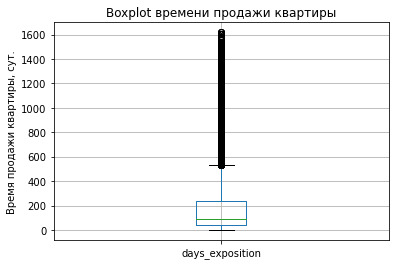

In [46]:
df.boxplot(column='days_exposition')
plt.title('Boxplot времени продажи квартиры')
plt.ylabel('Время продажи квартиры, сут.')
plt.show()

Тут выбросов тоже очень много. Объявления, которые провисели больше 550 дней - выбросы.

#### Сделаем чистый фрейм без выбросов. Назовем его df_final.

In [47]:
df_final = df.query('1 <= rooms <= 6 and 0.8 <= last_price <= 12 and 12 <= total_area <= 120 and 2.3 <= ceiling_height <= 3.1 and 1 <= days_exposition <= 550').reset_index()
#df_final.info()

##### Рассчитаем коэффициенты корреляции между ценой и площадью/количеством комнат/расстоянием до центра. <a id="dependence"></a>

In [48]:
print('Корреляция цены и площади:', df_final['last_price'].corr(df_final['total_area']))
print('Корреляция цены и количества комнат:',df_final['last_price'].corr(df_final['rooms']))
print('Корреляция цены и расстояния до центра города:',df_final['last_price'].corr(df_final['cityCenters_nearest']))
print('Корреляция цены за м2 и количества комнат:',df_final['price_per_meter'].corr(df_final['rooms']))
print('Корреляция цены за м2 и площади:',df_final['price_per_meter'].corr(df_final['total_area']))

Корреляция цены и площади: 0.6938026831727491
Корреляция цены и количества комнат: 0.4244237685238601
Корреляция цены и расстояния до центра города: -0.3186100006964734
Корреляция цены за м2 и количества комнат: -0.24551600030873189
Корреляция цены за м2 и площади: -0.09125588753686642


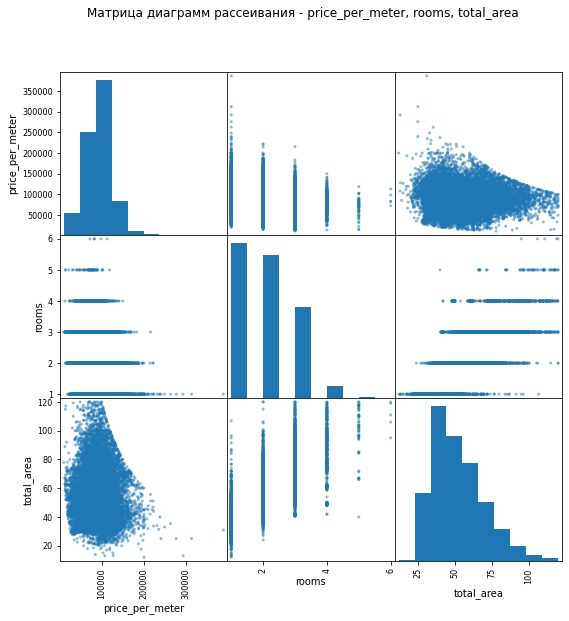

In [49]:
df_corr = df_final[['price_per_meter', 'rooms','total_area']]
#df_corr
pd.plotting.scatter_matrix(df_corr, figsize=(9,9))
plt.suptitle('Матрица диаграмм рассеивания - price_per_meter, rooms, total_area')
plt.show()

Цена и площадь сильно коррелируют между собой - между значениями линейная зависимость, при увеличении площади квартир, цена растет и наоборот.

Цена и количество комнат, цена и расстояние до центра коррелируют слабо между собой, но это требует проверки.

##### Построим график зависимости цены от количества комнат.

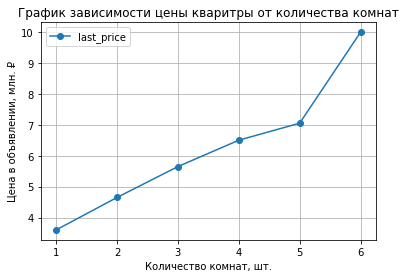

In [50]:
df_final.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(style='o-', grid=True)
plt.title('График зависимости цены кваритры от количества комнат')
plt.xlabel('Количество комнат, шт.')
plt.ylabel('Цена в объявлении, млн. ₽')
plt.show()

По этому графику наглядно видно, как при увеличении числа комнат растет цена на квартиру, что очевидно - больше комнат, больше площадь, больше цена.

Но есть подозрение, что цена квадратного метра должна падать при увеличении числа комнат в квартире. Выведем этот же график, только в values поставим price_per_meter.

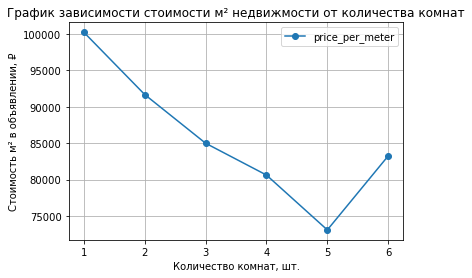

In [51]:
df_final.pivot_table(index='rooms', values='price_per_meter', aggfunc='median').plot(style='o-', grid=True)
plt.title('График зависимости стоимости м² недвижмости от количества комнат')
plt.xlabel('Количество комнат, шт.')
plt.ylabel('Стоимость м² в объявлении, ₽')
plt.show()

Однушки по цене за квадрат самые дорогие и до пяти комнатных цены квадрата снижаются, шести-комнатные квартиры по графику имеют скачек цены за метр. Возможно, это мой просчет во время удаления "выбросом" и 6-комнатая квартира является редкостью в Питере или относится к элитному жилью, или 6-комнатные есть только в центре Питера в стареньких домах.

##### Построим график зависимости цены от удаленности квартиры от центра. 

Для начала поделим на равные части значения расстояний до центра методом qcut на 15 частей.

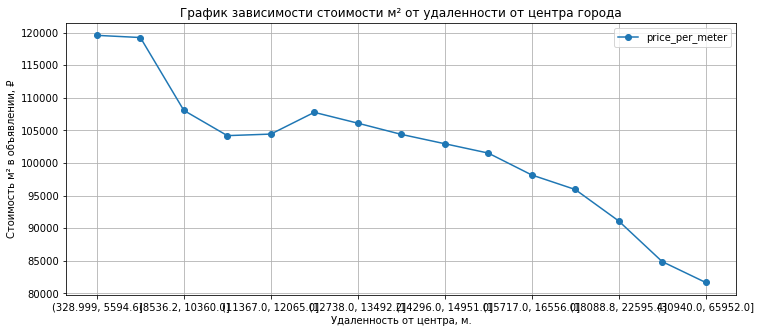

In [52]:
df_final['cityCenters_nearest_cut'] = pd.qcut(df_final['cityCenters_nearest'],15)
df_final.pivot_table(index='cityCenters_nearest_cut', values=['price_per_meter'], aggfunc='mean').plot(figsize=(12,5), style='o-', grid=True)
plt.title('График зависимости стоимости м² от удаленности от центра города')
plt.xlabel('Удаленность от центра, м.')
plt.ylabel('Стоимость м² в объявлении, ₽')
plt.show()

По графику видно как цена квадратного метра постепенно падает в зависимости от удаленности от центра. Сначала идет резкий "спуск" до 8-9 км. и после график становится плавнее со скачком цены в удаленности от центра 12-13 км. Возможно, этот скачек показывает цены на квартиры в новых районах на окраине Петербурга с хорошими домами и большими площадями квартир (или в этих районах есть сильный спрос на жилье, что позволило продавцам "подкорректировать" цену).

Цена квартиры и цена за квадратный метр будет иметь подобный график в зависимости от удаленности от центра.

##### Зависимость цены от этажа (первый, последний, другой).

Выведем сводную таблицу этажу и медианной цене за метр.

             price_per_meter
floor_group                 
первый          80899.890039
последний       85454.545455
другие          96153.846154


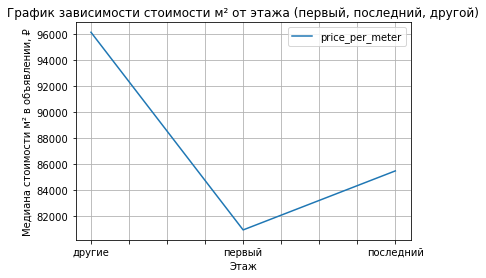

In [53]:
floor_pivot = df_final.pivot_table(index='floor_group', values='price_per_meter', aggfunc='median')
print(floor_pivot.sort_values('price_per_meter'))
floor_pivot.plot(grid=True)
plt.title('График зависимости стоимости м² от этажа (первый, последний, другой)')
plt.xlabel('Этаж')
plt.ylabel('Медиана стоимости м² в объявлении, ₽')
plt.show()

По сводной таблице уже сразу видно, что цена за квадрат больше всего у этажей между первым и последним. Первый этаж с медианой 80 тысяч за квадрат дешевле всех остальных - тут всё понятно, я сам на первом этаже живу =) Разница между первым и другими болше 15%, что существенно влияет на итоговую цену квартиры. На последнем этаже квартиры дешевле, но не настолько как на первом - на 10% меньше, чем на других.

График показал нам "галку" - высокая цена, низкая цена, средняя цена.

##### Зависимость от даты размещения: дня недели, месяца и года.

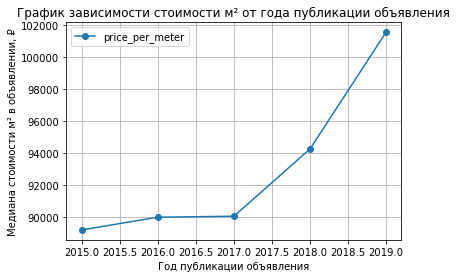

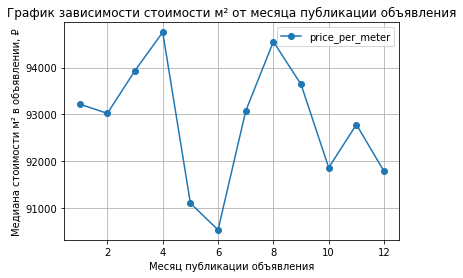

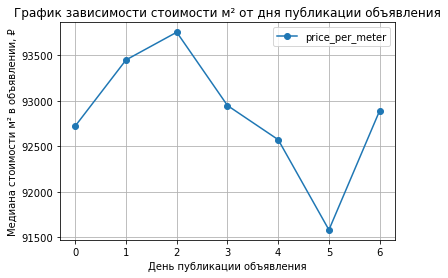

In [54]:
df_final.pivot_table(index='year', values='price_per_meter', aggfunc='median').plot(style='o-', grid=True)
plt.title('График зависимости стоимости м² от года публикации объявления')
plt.xlabel('Год публикации объявления')
plt.ylabel('Медиана стоимости м² в объявлении, ₽')
plt.show()
df_final.pivot_table(index='month', values='price_per_meter', aggfunc='median').plot(style='o-', grid=True)
plt.title('График зависимости стоимости м² от месяца публикации объявления')
plt.xlabel('Месяц публикации объявления')
plt.ylabel('Медиана стоимости м² в объявлении, ₽')
plt.show()
df_final.pivot_table(index='weekday', values='price_per_meter', aggfunc='median').plot(style='o-', grid=True)
plt.title('График зависимости стоимости м² от дня публикации объявления')
plt.xlabel('День публикации объявления')
plt.ylabel('Медиана стоимости м² в объявлении, ₽')
plt.show()

С годами цены за квадрат растут, как и все цены вокруг. Но с 2017 по 2019 года цены сильно "подскочили" с 90 тысяч за квадрат, до 102 тысяч. Разные факторы могли повлиять на такой скачек - так как проценты по вкладам в банках падают люди вытаскивают деньги из банков и вкладывают их в недвижимость, экономическая обстановка как минимум на "троечку", также Питер сильно меньше Москвы и площадей для застройки сильно меньше, а спрос в таком красивом городе на недвижимость явно есть.

Цена объявлений по осени сильно больше и к концу цена опускается. Видимо самый большой спрос на квартиры начинает с конца лета и до нового года, те кто продают квартиры рассчитывают продать их до конца года, но если не успевают, то в декабре "роняют" цену.

По средам цены выше чем в остальные дни недели. По проекту "Музыка" мы помним, что Питерцы активизируются в среду, и скорее всего статистика сайтов объявлений о продаже квартир, показывает, что больше всего просмотров в середине недели, хитрые продавцы знают это и выкладывают объявления по бОльшей цене именно в этот день.

#### Сделаем список 10 городов в которых продается больше всего квартиры и выведем сводную таблицу со средними ценами за метр в этих городах. <a id="top10">

In [55]:
df_locations = df_final.pivot_table(index='locality_name', values='last_price', aggfunc='count')
top10_locations = df_locations.sort_values(['last_price'], ascending=False).head(10)
top10_list = top10_locations.index.tolist()
top_10_final = df_final.query('locality_name in @top10_list')
top_10_final_pivot = top_10_final.pivot_table(index='locality_name', values='price_per_meter', aggfunc={'mean','count'}).sort_values('mean', ascending=False)
top_10_final_pivot.columns = ['Количество объявлений','Средняя цена, м²']
top_10_final_pivot

,Количество объявлений,"Средняя цена, м²"
locality_name,,
Санкт-Петербург,11982,105366.065747
Пушкин,292,99735.634737
деревня Кудрово,255,92254.152958
посёлок Парголово,307,90223.814048
посёлок Мурино,464,85255.530833
посёлок Шушары,408,78454.854537
Колпино,309,75100.784997
Гатчина,274,68797.769290
Всеволожск,344,66871.604804


Лидером по цене за квадрат, ожидаемо, стал Санкт-Петербург - 105 тыс. руб. за квадрат. Аутсайдером в топ-10 стал город Выборг - цена за квадрат почти в два раза меньше, чем в Питере - 57,6 тысяч за квадрат.

Для красоты выведем схематичную картинку с картой Питера и окрестностей.

In [56]:
Image(url= "http://reklamapm.ru/wp-content/uploads/2017/06/226a16e616d4a20cc983879c3f46da21c136deba.png")

### Изучим предложения квартир в Санкт-Петербурге. <a id="center">

Создадим отдельный фрейм для Спб.

In [57]:
spb = 'Санкт-Петербург'
df_spb = df_final.query('locality_name in @spb').reset_index()
#df_spb.info()

Добавим новый столбец с расстоянием до центра в километрах и округлим его.

In [58]:
df_spb['to_center'] = (df_spb['cityCenters_nearest']/1000).round(0).astype(int)
#df_spb.head()

In [59]:
spb_pivot = df_spb.pivot_table(index='to_center', values='price_per_meter', aggfunc='mean')
spb_pivot

,price_per_meter
to_center,
0,110780.312125
1,121157.786857
2,119900.383274
3,108733.818500
4,118153.940313
5,124755.142862
6,124417.944850
7,118445.787393
8,115977.777678


Максимальное значение цены в 5 км. от центра.

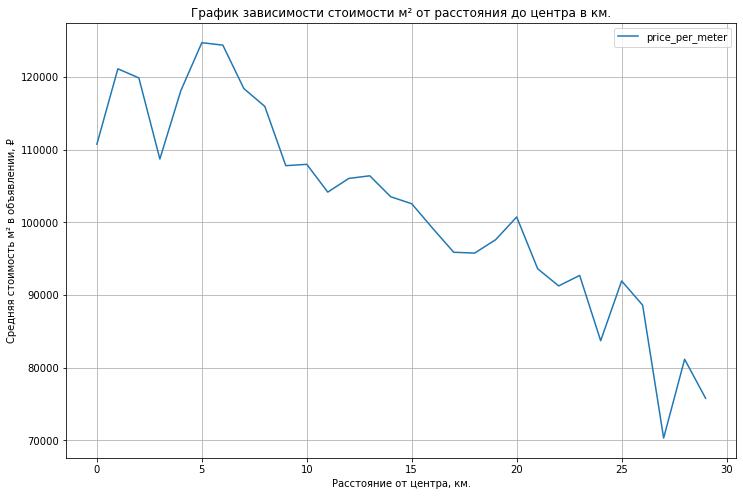

In [60]:
spb_pivot.plot(figsize=(12,8), grid=True)
plt.title('График зависимости стоимости м² от расстояния до центра в км.')
plt.xlabel('Расстояние от центра, км.')
plt.ylabel('Средняя стоимость м² в объявлении, ₽')
plt.show()

До пяти километров от центра нет стабильности по цене, цену "колбасит". Перевалив за 5 км. график начинает равномерно убывать до Ленинградской области. 

Предлагаю отнести центр Питера к радиусу 5 км. от центра. Так как возможно цену "колбасит" по причине того, что жилье в центре разное - старые "непонятные" обветшалые квартиры с разноплановой площадью, сделанные "модные" квартиры.

#### Выделим сегмент квартир в центре Санкт-Петербурга. Проанализируем эту территорию.

In [61]:
df_spb_center = df_spb.query('to_center <= 5')
#df_spb_center.head()
#df_spb_center.info()

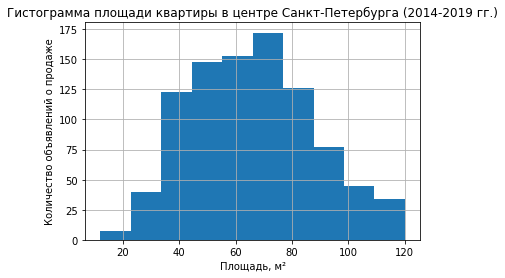

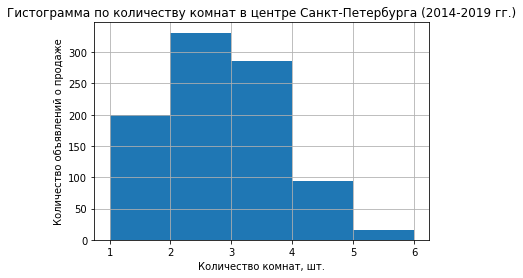

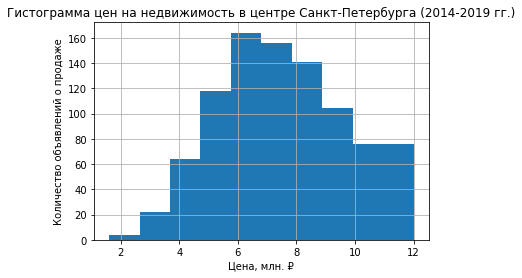

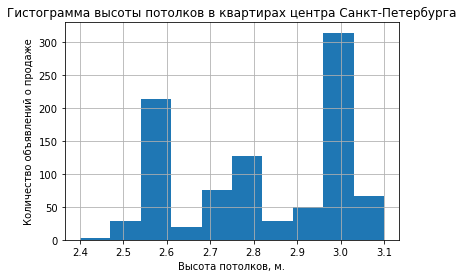

In [62]:
df_spb_center['total_area'].hist()
plt.title('Гистограмма площади квартиры в центре Санкт-Петербурга (2014-2019 гг.)')
plt.xlabel('Площадь, м²')
plt.ylabel('Количество объявлений о продаже')
plt.show()
df_spb_center['rooms'].hist(bins=5)
plt.title('Гистограмма по количеству комнат в центре Санкт-Петербурга (2014-2019 гг.)')
plt.xlabel('Количество комнат, шт.')
plt.ylabel('Количество объявлений о продаже')
plt.show()
df_spb_center['last_price'].hist()
plt.title('Гистограмма цен на недвижимость в центре Санкт-Петербурга (2014-2019 гг.)')
plt.xlabel('Цена, млн. ₽')
plt.ylabel('Количество объявлений о продаже')
plt.show()
df_spb_center['ceiling_height'].hist()
plt.title('Гистограмма высоты потолков в квартирах центра Санкт-Петербурга')
plt.xlabel('Высота потолков, м.')
plt.ylabel('Количество объявлений о продаже')
plt.show()


Мы посмотрели на гистограммы по основным параметрам в центре Питера. В

В центре Санкт-Петербурга пик по площади отличается от основного фрейма, в центре квартиры больше по площади и по количеству комнат, пик по площади в центре около 70 метров и в центре преобладают двушки и трешки, а в основном фрейме у нас была медиана по площади 52 кв. м, и большего всего было двушек и однушек.

Цены в центре, естественно, выше чем в основном фрейме и значения больше 12 млн. рублей здесь уже не кажутся выбросами.

Ну а по полку тут явное отличие - пик на 3-х метрах - хорошая жизнь она другая, 3 метра это конечно - супер. Хотя есть и второй пик, похожий на пик общего фрейма - 2,55 метра.

In [63]:
print('Корреляция цены и площади:', df_spb_center['last_price'].corr(df_spb_center['total_area']))
print('Корреляция цены и количества комнат:',df_spb_center['last_price'].corr(df_spb_center['rooms']))
print('Корреляция цены и расстояния до центра города:',df_spb_center['last_price'].corr(df_spb_center['cityCenters_nearest']))
print('Корреляция цены и этажа:',df_spb_center['last_price'].corr(df_spb_center['floor']))

Корреляция цены и площади: 0.6571623739396815
Корреляция цены и количества комнат: 0.42875966226643925
Корреляция цены и расстояния до центра города: -0.04223566298665219
Корреляция цены и этажа: 0.16554772756734393


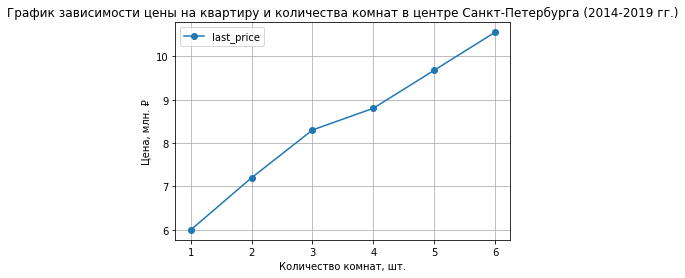

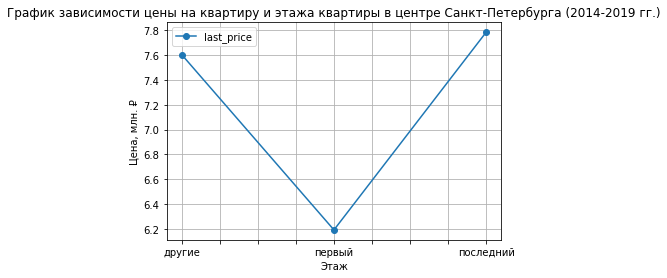

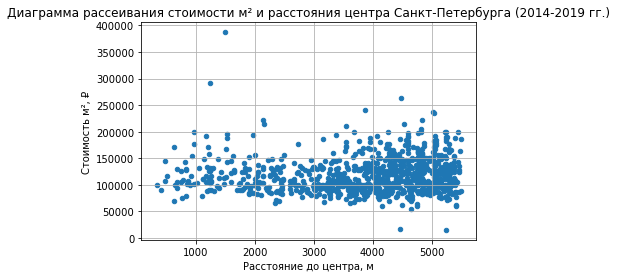

In [64]:
df_spb_center.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(style='o-', grid=True)
plt.title('График зависимости цены на квартиру и количества комнат в центре Санкт-Петербурга (2014-2019 гг.)')
plt.xlabel('Количество комнат, шт.')
plt.ylabel('Цена, млн. ₽')
plt.show()
df_spb_center.pivot_table(index='floor_group', values='last_price', aggfunc='median').plot(style='o-', grid=True)
plt.title('График зависимости цены на квартиру и этажа квартиры в центре Санкт-Петербурга (2014-2019 гг.)')
plt.xlabel('Этаж')
plt.ylabel('Цена, млн. ₽')
plt.show()
df_spb_center.plot(x='cityCenters_nearest', y='price_per_meter', kind='scatter', grid=True)
plt.title('Диаграмма рассеивания стоимости м² и расстояния центра Санкт-Петербурга (2014-2019 гг.)')
plt.xlabel('Расстояние до центра, м')
plt.ylabel('Стоимость м², ₽')
plt.show()

В зависимости от количество комнат квартиры растут в цене, странно что цена опускается вниз, когда количество комнат переваливает за 5. Видимо, спрос на такие квартиры меньше и приходится продавать дешевле.

В зависимости от этажности тут тоже "галка", но совсем другая. Да, первый этаж так и остается на дне по цене, но в центре самые дорогие квартиры на последнем этаже - шикарный вид на центр, добавляет стоимости.

Цены в зависимости от удаленности взаимосвязаны не сильно, квартир в трех километрах от центра сильно меньше чем в 4-5 километрах. В 4-5 километрах и квартир больше и цены "выскакивают" побольше, хотя самая дорогая квартира находится в радиусе 1,5 км с ценой почти 400 тысяч за квадратный метр.

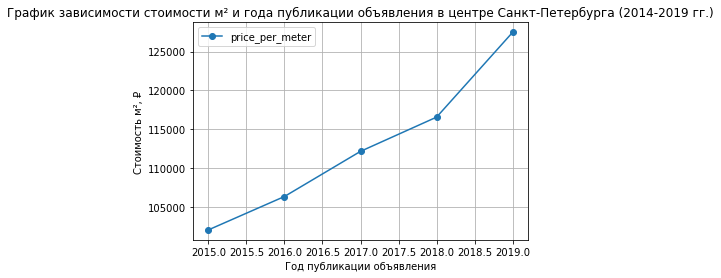

In [65]:
df_spb_center.pivot_table(index='year', values='price_per_meter', aggfunc='median').plot(style='o-', grid=True)
plt.title('График зависимости стоимости м² и года публикации объявления в центре Санкт-Петербурга (2014-2019 гг.)')
plt.xlabel('Год публикации объявления')
plt.ylabel('Стоимость м², ₽')
plt.show()

Цена с годами растет и в центре, только средняя цена за метр больше и выросла за пять лет с 95 тысяч рублей до 128 тысяч.

### Шаг 5. Общий вывод. <a id="result"></a>

###### Исходные данные.
В вашем распоряжении  были данные сервиса Яндекс.Недвижимость о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. По каждой квартире на продажу были доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.

В исходной таблице мы получили 23699 объявлениях о продаже квартир и 22 параметра по ним. Данные далеки от идеальных - во многих колонках есть пропущенные значения, есть аномалии такие как квартиры с площадью 900 м² и квартиры-крошки в 12 м², при медиане в 52 м², есть 19 комнатные квартиры и есть где количество комнат нулевое, квартиры с потолками 100 м и с потолком 1м, и объявление, которое «провисело» более 4-х лет при среднем времени размещения объявления в полгода.

###### Предобработка данных.
Были выявлены и заменены пустые значения в столбцах balcony и is_apartment. Мы предположили, что пустые значения в колонках balcony и is_apartment появились по причине не заполнения этих данных – балкон в квартире отсутствует, значит объявление не заполнено по этому параметру и мы заменили пустые значения на 0 и тоже самое проделали со значениями apartment. 

А нулевые значения количества комнат - это квартиры-студии и КГТ, оставили нули без изменений и запомнили информацию об этом. 

Расстояние до центра города – отсутствующие значения заменили на медиану по сгруппированным по населенному пункту данным. Этот метод не показал особой эффективности, было 5519 пропущенных значения и после применения метода стало 5394 пропущенных значения. Это связано с тем, что в данных очень много единичных населенных пунктов и нет возможности получить сгруппированные данные по этим населенным пунктам.

Пропущенные величины по высоте потолка мы заполнили также медианой, но сгруппировав данные по двум параметрам - floors_total и locality_name, потому что в одинаковых районах и одинаковых по количеству этажей домах обычно типовые квартиры с одинаковой высотой потолков (3-я улица Строителей дом 25=)). Было  9195 пропусков, стало 503 пропуска. Таким образом мы убрали большую часть пропусков в высоте потолка, остатки оставили незаполненными - это потолки квартир в маленькие населенных пунктах, скорее всего на наш анализ отсутствие этих значений не повлияет.

Также в данных были обнаружены пропущенные значения в столбцах floors_total, living_area, kithen_area, locality_name, days_exposition, cityCenters_nearest - это данные, которые потребуются в той или иной мере для анализа, но "добыть" правдоподобную информацию по этим параметрам проблематично. Оставим эти значения с пропусками как есть.
Данные airports_nearest, park_around3000, ponds_around3000, park_nearest и ponds_nearest - в исследование применятся не будут, поэтому будут проигнорированы - всё что могли изменили на более подходящии типы данных для экономии памяти.


Мои предположения о причине отсутствия данных:
*	floors_total - пользователь мог не внести подобную информацию в объявление;
*	living_area, kithen_area - указана только общая площадь квартиры, опять недозаполнили объявления;
*	locality_name, cityCenters_nearest - не указан геотег по объявлению или пользователь указал адрес квартиры в неверной графе, в связи с чем картографические данные не удалось выгрузить автоматически;
*	days_exposition - на момент выгрузки данных, квартира могла быть еще не продана и объявление числилось как активное без даты снятия с публикации.
Мы заменили типы данных на int:
*	по количеству балконов;
*	по значению is_apartment, т.к. это булевы значения, где 0 - False, 1 – True;
*	по значению last_price, для удобства

Привели значения в колонке с днем первой публикации к формату читаемой даты для дальнейшего анализа.

Посчитали и добавили в таблицу цену квадратного метра недвижимости.

После того, как получили цены квадратного метра перевели цену квартиры в миллионы для дальнейшего удобства.

Добавили в таблицу день недели, месяц и год публикации, добавили столбец с группой по этажу – первый, последний, другие, посчитали и добавили отношения жилой площади к общей и отношение площади кухни к общей площади.

Значения NaN, которые заменить логически тяжело мы оставили в таблице без изменений, чтобы не испортить данные своими вмешательствами.

###### Исследование данных.

1) Площадь, цена, число комнат, высота потолков.

Построив гистограммы мы определили, что типичными квартирами в нашей выборке стали квартиры площадью 30-70 м² (на графике от 12 м² до 900 м² ), от однокомнатных до трёхкомнатных с выбивающимися значениями аж до 19 комнат, но было замечено много 4-6 комнатных квартир, с высотой потолков 2.5 – 3 м (выбросы от 1 м до 100 м вверх) по цене от 4-х до 9-и миллионов рублей и тоже с выбросами.

График помог нам вычислить, что в среднем квартиры продаются полгода, по медиане мы видим, что квартиры продаются 95 дней. Считаю логичным отнести быстрые продажи квартиры к значениям вокруг первого квартиля - если квартира продалась от 30 до 60 дней, то можем считать это быстрой продажей.
Значения гистограммы подходят к нулю после объявлений, "провисевших" более 800 дней (более двух лет), после этого значения продажи квартир, считаю становится необычно долгими. Также можем считать, что просто долгая продажа может считаться после года с момента публикации объявления.

2) Выбросы, поиск и устранение.

Для поиска выбросов был применен метод построения графика boxplot. После просмотра боксплотов был сделан обновленный дата фрейм – оставили 1-6 комнатные квартиры, с ценой от 800 тысяч до 12 миллионов, с площадью 12-120 квадратов, потолки 2.3-3.1 метр и со срокам нахождения объявления на сайте от одного до 550 дней.

###### Поиск зависимостей.

1) Мы посчитали коэффициенты корреляции.

Корреляция цены и площади: 0.69

Корреляция цены и количества комнат: 0.42

Корреляция цены и расстояния до центра города: -0.32

Корреляция цены м2 и количества комнат: -0.25

Корреляция цены м2 и площади: -0.09

Цена и площадь сильно коррелируют между собой - между значениями линейная зависимость, при увеличении площади квартир, цена растет и наоборот.
Остальные данные коррелируют слабо между собой, поэтому мы посмотрели на данные по графикам.
Количество комнат и цены:
Было выявлено, что при увеличении числа комнат растёт цена на квартиру, что очевидно - больше комнат, больше площадь, больше цена. Но цена квадратного уменьшалась при увеличении числа комнат в квартире. 

Однушки по цене за квадрат самые дорогие и до пяти комнатных цены квадрата снижаются, шести-комнатные квартиры по графику имели скачек цены за метр. Возможно, это мой просчет во время удаления "выбросов" и 6-комнатая квартира является редкостью в Питере или относится к элитному жилью, или 6-комнатные есть только в центре Питера в стареньких домах.

Также была построена матрица диаграмм рассеивания и было выявлено, что цена квадратного метра дешевле у больших квартир и также цена за квадрат зависит и от количества комнат - оптом квадратные метры продаются чуть дешевле, но в целом большая квартира, конечно, дороже.

2) Удалённость от центра:

Цены квадратного метра постепенно падает в зависимости от удаленности от центра. Сначала идет резкий "спуск" до 8-9 км. и после график становится плавнее со скачком цены в удаленности от центра 12-13 км. Возможно, этот скачек показывает цены на квартиры в новых районах на окраине Петербурга с хорошими домами и большими площадями квартир (или в этих районах есть сильный спрос на жилье, что позволило продавцам "подкорректировать" цену).

3) Разница между первым, последним и другими этажами:

Цены за квадрат больше всего у этажей между первым и последним. Первый этаж с медианой 80 тысяч за квадрат дешевле всех остальных - тут всё понятно, я сам на первом этаже живу =) Разница между первым и другими больше 15%, что существенно влияет на итоговую цену квартиры. На последнем этаже квартиры дешевле, но не настолько как на первом - на 10% меньше, чем на других. График показал нам "галку" - высокая цена, низкая цена, средняя цена.

4) Влияние дат на цену:

С годами цены за квадрат растут, как и все цены вокруг. Но с 2017 по 2019 года цены сильно "подскочили" с 90 тысяч за квадрат, до 102 тысяч. Разные факторы могли повлиять на такой скачек - так как проценты по вкладам в банках падают люди вытаскивают деньги из банков и вкладывают их в недвижимость, экономическая обстановка как минимум на "троечку", также Питер сильно меньше Москвы и площадей для застройки сильно меньше, а спрос в таком красивом городе на недвижимость явно есть.
Цена объявлений по осени сильно больше и к концу года цена опускается. Видимо самый большой спрос на квартиры начинает с конца лета и до нового года, те кто продают квартиры рассчитывают продать их до конца года, но если не успевают, то в декабре "роняют" цену.
По средам цены выше чем в остальные дни недели. По проекту "Музыка" мы помним, что Питерцы активизируются в среду, и скорее всего статистка сайтов объявлений о продаже квартир, показывает, что больше всего просмотров в середине недели - хитрые продавцы знают это и выкладывают объявления по бОльшей цене именно в этот день.

###### Топ-10 городов по количеству объявлений:
Мы определили топ-10 городов с наибольшим количеством объявлений о продаже квартир и рассчитали среднюю стоимость за квадрат. Лидером по цене за квадрат и количеством объявлений, ожидаемо, стал Санкт-Петербург - 105 тыс. руб. за квадрат и около половины всех объявлений приходятся на Питер. Аутсайдером в топ-10 стал город Выборг - цена за квадрат почти в два раза меньше, чем в Питере - 57 тысяч за квадрат и всего 181 объявление о продаже.

#### Санкт-Петербург, центр города.
После построения графика зависимости цены от удаленности от центра мы отнесли центр Питера в радиус 5 км от нулевой точки. График был нестабильным до 5 км - возможно цену "колбасило" по причине того, что жилье в центре разное - старые "непонятные" обветшалые квартиры с разноплановой площадью или сделанные "модные" квартиры.

Центр Санкт-Петербурга отличился от основных данных. В центре квартиры больше по площади и по количеству комнат, пик по площади в центре около 70 метров и в центре преобладают двушки и трешки, а в основном фрейме у нас была медиана по площади 52 кв. м, и большего всего было двушек и однушек.
Цены в центре, естественно, выше чем в основном фрейме и значения больше 12 млн. рублей здесь уже не кажутся выбросами.
Ну и по высоте потолка тут явное отличие - пик графика был 3-х метрах - центральная жизнь она другая, шикарная. Хотя был и второй пик, похожий на пик общего фрейма - 2,55 метра.

###### Зависимости в центре города.

В зависимости от количество комнат квартиры растут в цене, странно что цена опускается вниз, когда количество комнат переваливает за 5. Видимо, спрос на такие квартиры меньше и приходится продавать дешевле.
В зависимости от этажности тут тоже обнаружена зависимость, но совсем другая. Да, первый этаж так и остается «на дне» по цене, но в центре самые дорогие квартиры на последнем этаже - шикарный вид на центр, добавляет стоимости.
Цены в зависимости от удаленности взаимосвязаны не сильно, квартир в трех километрах от центра сильно меньше чем в 4-5 километрах. В 4-5 километрах и квартир больше и цены "выскакивают" побольше, хотя самая дорогая квартира находится в радиусе 1,5 км с ценой почти 400 тысяч за квадратный метр.

Цена с годами растет и в центре, только средняя цена за метр больше и выросла за пять лет с 95 тысяч рублей до 127 тысяч. И график более плавный, без резкого увеличения цены по году.


#### Итог.
Мы установили типичные квартиры для Санкт-Петербурга и близлежащих городов, наглядно показали зависимости цен от разных параметеров квартиры. Отдельно выделили центр Санкт-Петербурга с его типичным жильем, которое отличалось от общих данных и нашли интересные зависимости и тут. Выявили среднерыночную стоимость жилья как в центре так и по всему региону.

Эти данные позволяют понимать рынок недвижимости в Петербурге, выявлять нестандартные квартиры и понять выше или ниже рыночной стоимость опубликованные объявления о продаже квартиры. Также полученный результат поможет предостеречь пользователей от слишком низкой стоимости квартиры в объявлении и сверстать баннер с предупреждениями на сайт.

### Чек-лист готовности проекта

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод